In [228]:
import sys
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import timedelta  as td
from datetime import datetime as dt

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal
from scipy import stats

1. Please download the historical prices and dates of gold and silver from these 2 URLs (Jan 2019 till now):

 

•             https://www.investing.com/commodities/gold-historical-data

•             https://www.investing.com/commodities/silver-historical-data

 

and store them locally (in a file or database, as you see fit).

In [5]:
#the 'Price' column in the gold csv was importing as object instead of float 
#so i added the thousands=',' to account for the comma
silver_df = pd.read_csv('./data/Silver Futures Historical Data.csv',sep=',', thousands=',')
gold_df = pd.read_csv('./data/Gold Futures Historical Data.csv',sep=',', thousands=',')

In [6]:
silver_df['Date']= pd.to_datetime(silver_df['Date'])
gold_df['Date']= pd.to_datetime(gold_df['Date'])

In [7]:
silver_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 7 columns):
Date        139 non-null datetime64[ns]
Price       139 non-null float64
Open        139 non-null float64
High        139 non-null float64
Low         139 non-null float64
Vol.        139 non-null object
Change %    139 non-null object
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 7.7+ KB


In [12]:
silver_df.head(100)

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-06-11,14.738,14.695,14.783,14.633,-,0.28%
1,2019-06-10,14.697,14.973,14.998,14.627,-,-1.84%
2,2019-06-09,14.973,15.008,15.008,14.953,-,-0.21%
3,2019-06-07,15.005,14.852,15.148,14.842,-,1.00%
4,2019-06-06,14.857,14.793,14.988,14.732,-,0.43%
5,2019-06-05,14.793,14.812,15.037,14.758,-,-0.09%
6,2019-06-04,14.807,14.768,14.848,14.648,-,0.26%
7,2019-06-03,14.768,14.602,14.822,14.568,-,1.14%
8,2019-06-02,14.602,14.555,14.602,14.555,-,0.32%
9,2019-05-31,14.555,14.510,14.668,14.457,-,0.32%


/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Silver Closing Prices')

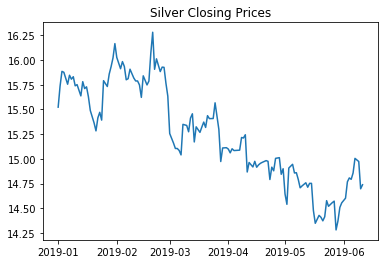

In [9]:
plt.plot(silver_df['Date'],silver_df['Price'])
plt.title('Silver Closing Prices')

In [10]:
gold_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 7 columns):
Date        119 non-null datetime64[ns]
Price       119 non-null float64
Open        119 non-null float64
High        119 non-null float64
Low         119 non-null float64
Vol.        119 non-null object
Change %    119 non-null object
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 6.6+ KB


In [11]:
gold_df.describe()

,Price,Open,High,Low
count,119.000000,119.000000,119.000000,119.000000
mean,1303.330252,1303.268487,1308.655882,1297.856723
std,19.396968,19.113329,19.817903,18.746011
min,1272.000000,1271.600000,1277.100000,1267.300000
25%,1285.950000,1286.400000,1290.600000,1282.625000
50%,1301.300000,1300.800000,1307.700000,1293.600000
75%,1320.550000,1319.150000,1324.925000,1313.700000
max,1354.400000,1350.300000,1356.000000,1346.800000


In [64]:
gold_df.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-06-11,1331.55,1333.25,1333.75,1323.65,-,0.52%
1,2019-06-10,1324.70,1335.80,1336.50,1324.10,0.27K,-1.23%
2,2019-06-07,1341.20,1333.10,1347.70,1329.80,0.24K,0.27%
3,2019-06-06,1337.60,1330.80,1338.70,1326.20,0.16K,0.70%
4,2019-06-05,1328.30,1328.90,1343.30,1326.30,0.62K,0.37%
5,2019-06-04,1323.40,1324.30,1328.60,1320.80,0.30K,0.05%
6,2019-06-03,1322.70,1307.00,1327.80,1307.00,0.81K,1.29%
7,2019-05-31,1305.80,1287.70,1306.40,1287.50,2.81K,1.45%
8,2019-05-30,1287.10,1279.40,1288.30,1273.90,55.57K,0.48%
9,2019-05-29,1281.00,1278.90,1285.20,1278.40,189.69K,0.31%


Text(0.5, 1.0, 'Gold Closing Prices')

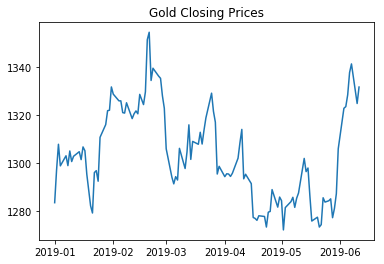

In [65]:
plt.plot(gold_df['Date'],gold_df['Price'])
plt.title("Gold Closing Prices")

In [98]:
gold_df['Price'].values

array([1331.55, 1324.7 , 1341.2 , 1337.6 , 1328.3 , 1323.4 , 1322.7 ,
       1305.8 , 1287.1 , 1281.  , 1277.1 , 1284.95, 1284.15, 1283.6 ,
       1285.4 , 1274.2 , 1273.2 , 1277.3 , 1275.7 , 1286.2 , 1297.8 ,
       1296.3 , 1301.8 , 1287.4 , 1285.2 , 1281.4 , 1285.6 , 1283.8 ,
       1281.3 , 1272.  , 1284.2 , 1285.7 , 1281.5 , 1288.8 , 1279.7 ,
       1279.4 , 1273.2 , 1277.6 , 1277.9 , 1276.  , 1276.8 , 1277.2 ,
       1291.3 , 1295.2 , 1293.3 , 1313.9 , 1308.3 , 1301.9 , 1295.6 ,
       1294.3 , 1295.3 , 1295.4 , 1294.2 , 1298.5 , 1295.3 , 1316.9 ,
       1321.4 , 1329.  , 1318.7 , 1313.6 , 1307.8 , 1312.7 , 1307.7 ,
       1308.9 , 1301.4 , 1315.8 , 1304.5 , 1297.6 , 1306.  , 1292.8 ,
       1294.2 , 1291.2 , 1294.  , 1305.8 , 1322.7 , 1327.9 , 1335.2 ,
       1336.1 , 1339.4 , 1334.3 , 1354.4 , 1351.3 , 1329.55, 1324.25,
       1328.5 , 1320.4 , 1321.6 , 1320.4 , 1318.4 , 1325.  , 1320.7 ,
       1320.9 , 1325.8 , 1325.8 , 1328.6 , 1331.6 , 1321.9 , 1321.7 ,
       1315.9 , 1310

In [100]:
metal

Date
2019-04-01    1294.20
2019-04-02    1295.40
2019-04-03    1295.30
2019-04-04    1294.30
2019-04-05    1295.60
2019-04-08    1301.90
2019-04-09    1308.30
2019-04-10    1313.90
2019-04-11    1293.30
2019-04-12    1295.20
2019-04-15    1291.30
2019-04-16    1277.20
2019-04-17    1276.80
2019-04-18    1276.00
2019-04-19    1277.90
2019-04-22    1277.60
2019-04-23    1273.20
2019-04-24    1279.40
2019-04-25    1279.70
2019-04-26    1288.80
2019-04-29    1281.50
2019-04-30    1285.70
2019-06-03    1322.70
2019-06-04    1323.40
2019-03-01    1305.80
2019-03-04    1294.00
2019-03-05    1291.20
2019-03-06    1294.20
2019-03-07    1292.80
2019-03-08    1306.00
               ...   
2019-03-22    1318.70
2019-03-25    1329.00
2019-03-26    1321.40
2019-03-27    1316.90
2019-03-28    1295.30
2019-03-29    1298.50
2019-05-01    1284.20
2019-05-02    1272.00
2019-05-03    1281.30
2019-05-06    1283.80
2019-05-07    1285.60
2019-05-08    1281.40
2019-05-09    1285.20
2019-05-10    1287.40
2019-

#2. Please then write a program that takes the following 3 command line arguments:

* Start date (in the format 2017-05-10)

* End date (in the format 2017-05-22)

* Commodity type (either "gold" or silver”)

Then first describe the statistical properties of the data. Next, tell whether the data are stationary. Lastly, provide additional time series properties of interest, if any.


### Run precious_metal.py from the command line in a directory with the /data/ folder including historical gold and silver prices downloaded from above link. The work to create this program is below.


In [113]:
def load_precious_metals_data(start_date,end_date,name):
    #date will be used for the index, price as the value of interest. 
    #these can be changed in the variables below
    price = 'Price'
    date = 'Date'
    name = name
    #This function expects Gold Futures Historical Data.csv and Silver Futures Historical Data.csv 
    #in the ./data/ folder
    
    file_name = './data/{}'.format(''.join([ name, ' Futures Historical Data.csv']))
    print (file_name)
    df = pd.read_csv(file_name,sep=',', thousands=',')
    #df.sort_values(date,inplace=True)
    print(df)
    df = df.set_index(pd.to_datetime(df[date]),drop=True)
    df=df.sort_index()
    df=df.loc[start_date:end_date]

    #del df[date]
    print (df.describe())
    return pd.Series(df[price], df.index)

In [248]:
name = 'gold'
commodity = 'Gold'
start_date = '2019-03-01'
end_date = '2019-06-04'
metal = load_precious_metals_data(start_date,end_date,commodity)
metal

./data/Gold Futures Historical Data.csv
             Date    Price     Open     High      Low     Vol. Change %
0    Jun 11, 2019  1331.55  1333.25  1333.75  1323.65        -    0.52%
1    Jun 10, 2019  1324.70  1335.80  1336.50  1324.10    0.27K   -1.23%
2    Jun 07, 2019  1341.20  1333.10  1347.70  1329.80    0.24K    0.27%
3    Jun 06, 2019  1337.60  1330.80  1338.70  1326.20    0.16K    0.70%
4    Jun 05, 2019  1328.30  1328.90  1343.30  1326.30    0.62K    0.37%
5    Jun 04, 2019  1323.40  1324.30  1328.60  1320.80    0.30K    0.05%
6    Jun 03, 2019  1322.70  1307.00  1327.80  1307.00    0.81K    1.29%
7    May 31, 2019  1305.80  1287.70  1306.40  1287.50    2.81K    1.45%
8    May 30, 2019  1287.10  1279.40  1288.30  1273.90   55.57K    0.48%
9    May 29, 2019  1281.00  1278.90  1285.20  1278.40  189.69K    0.31%
10   May 28, 2019  1277.10  1283.50  1286.90  1275.10  362.16K   -0.61%
11   May 27, 2019  1284.95  1284.25  1286.85  1283.25        -    0.06%
12   May 26, 2019  1284.

Date
2019-03-01    1305.80
2019-03-04    1294.00
2019-03-05    1291.20
2019-03-06    1294.20
2019-03-07    1292.80
2019-03-08    1306.00
2019-03-11    1297.60
2019-03-12    1304.50
2019-03-13    1315.80
2019-03-14    1301.40
2019-03-15    1308.90
2019-03-18    1307.70
2019-03-19    1312.70
2019-03-20    1307.80
2019-03-21    1313.60
2019-03-22    1318.70
2019-03-25    1329.00
2019-03-26    1321.40
2019-03-27    1316.90
2019-03-28    1295.30
2019-03-29    1298.50
2019-04-01    1294.20
2019-04-02    1295.40
2019-04-03    1295.30
2019-04-04    1294.30
2019-04-05    1295.60
2019-04-08    1301.90
2019-04-09    1308.30
2019-04-10    1313.90
2019-04-11    1293.30
               ...   
2019-04-25    1279.70
2019-04-26    1288.80
2019-04-29    1281.50
2019-04-30    1285.70
2019-05-01    1284.20
2019-05-02    1272.00
2019-05-03    1281.30
2019-05-06    1283.80
2019-05-07    1285.60
2019-05-08    1281.40
2019-05-09    1285.20
2019-05-10    1287.40
2019-05-13    1301.80
2019-05-14    1296.30
2019-

In [249]:
metal

Date
2019-03-01    1305.80
2019-03-04    1294.00
2019-03-05    1291.20
2019-03-06    1294.20
2019-03-07    1292.80
2019-03-08    1306.00
2019-03-11    1297.60
2019-03-12    1304.50
2019-03-13    1315.80
2019-03-14    1301.40
2019-03-15    1308.90
2019-03-18    1307.70
2019-03-19    1312.70
2019-03-20    1307.80
2019-03-21    1313.60
2019-03-22    1318.70
2019-03-25    1329.00
2019-03-26    1321.40
2019-03-27    1316.90
2019-03-28    1295.30
2019-03-29    1298.50
2019-04-01    1294.20
2019-04-02    1295.40
2019-04-03    1295.30
2019-04-04    1294.30
2019-04-05    1295.60
2019-04-08    1301.90
2019-04-09    1308.30
2019-04-10    1313.90
2019-04-11    1293.30
               ...   
2019-04-25    1279.70
2019-04-26    1288.80
2019-04-29    1281.50
2019-04-30    1285.70
2019-05-01    1284.20
2019-05-02    1272.00
2019-05-03    1281.30
2019-05-06    1283.80
2019-05-07    1285.60
2019-05-08    1281.40
2019-05-09    1285.20
2019-05-10    1287.40
2019-05-13    1301.80
2019-05-14    1296.30
2019-

In [250]:
metal.values

array([1305.8 , 1294.  , 1291.2 , 1294.2 , 1292.8 , 1306.  , 1297.6 ,
       1304.5 , 1315.8 , 1301.4 , 1308.9 , 1307.7 , 1312.7 , 1307.8 ,
       1313.6 , 1318.7 , 1329.  , 1321.4 , 1316.9 , 1295.3 , 1298.5 ,
       1294.2 , 1295.4 , 1295.3 , 1294.3 , 1295.6 , 1301.9 , 1308.3 ,
       1313.9 , 1293.3 , 1295.2 , 1291.3 , 1277.2 , 1276.8 , 1276.  ,
       1277.9 , 1277.6 , 1273.2 , 1279.4 , 1279.7 , 1288.8 , 1281.5 ,
       1285.7 , 1284.2 , 1272.  , 1281.3 , 1283.8 , 1285.6 , 1281.4 ,
       1285.2 , 1287.4 , 1301.8 , 1296.3 , 1297.8 , 1286.2 , 1275.7 ,
       1277.3 , 1273.2 , 1274.2 , 1285.4 , 1283.6 , 1284.15, 1284.95,
       1277.1 , 1281.  , 1287.1 , 1305.8 , 1322.7 , 1323.4 ])

In [251]:
metal.diff().head()

Date
2019-03-01     NaN
2019-03-04   -11.8
2019-03-05    -2.8
2019-03-06     3.0
2019-03-07    -1.4
Name: Price, dtype: float64

In [252]:
def ADF_test(x,name):
    alpha = .05
    test = sm.tsa.stattools.adfuller(x.values)
    print(name," ADF p-value: {0:2.2f}".format(test[1]))
    print('A low p-value would indicate the data are stationary')

In [253]:
ADF_test(metal,commodity)

Gold  ADF p-value: 0.23
A low p-value would indicate the data are stationary


In [254]:
ADF_test(metal.diff()[1:],commodity)

Gold  ADF p-value: 0.00
A low p-value would indicate the data are stationary


In [255]:
gold_df.min()

Date        2019-01-01 00:00:00
Price                      1272
Open                     1271.6
High                     1277.1
Low                      1267.3
Vol.                          -
Change %                 -0.01%
dtype: object

In [256]:
ADF_test(silver_df['Price'],commodity)

Gold  ADF p-value: 0.42
A low p-value would indicate the data are stationary


In [257]:
ADF_test(silver_df['Price'].diff()[1:],commodity)

Gold  ADF p-value: 0.00
A low p-value would indicate the data are stationary


In [258]:
metal.loc['2019-01-07':'2019-01-03']

Series([], Name: Price, dtype: float64)

In [259]:
gold_df.describe()

,Price,Open,High,Low
count,119.000000,119.000000,119.000000,119.000000
mean,1303.330252,1303.268487,1308.655882,1297.856723
std,19.396968,19.113329,19.817903,18.746011
min,1272.000000,1271.600000,1277.100000,1267.300000
25%,1285.950000,1286.400000,1290.600000,1282.625000
50%,1301.300000,1300.800000,1307.700000,1293.600000
75%,1320.550000,1319.150000,1324.925000,1313.700000
max,1354.400000,1350.300000,1356.000000,1346.800000


In [260]:
gold_df.describe()[0:4:][-1::]


,Price,Open,High,Low
min,1272.0,1271.6,1277.1,1267.3


In [261]:
gold_df.describe()[0:4:]

,Price,Open,High,Low
count,119.000000,119.000000,119.000000,119.000000
mean,1303.330252,1303.268487,1308.655882,1297.856723
std,19.396968,19.113329,19.817903,18.746011
min,1272.000000,1271.600000,1277.100000,1267.300000


In [262]:
pd.concat([gold_df.describe()[0:4],gold_df.describe()[-1::]])

,Price,Open,High,Low
count,119.000000,119.000000,119.000000,119.000000
mean,1303.330252,1303.268487,1308.655882,1297.856723
std,19.396968,19.113329,19.817903,18.746011
min,1272.000000,1271.600000,1277.100000,1267.300000
max,1354.400000,1350.300000,1356.000000,1346.800000


3. Write a program to help you decide how useful the previous gold or silver prices are as predictors for their future prices.

Also determine if past prices are useful in predicting the direction of change (increase or decrease). There is no need to provide future predictions, and you may use whatever tests you deem useful.

Please feel free to use whatever language you think is best suited to the task and/or familiar to you.

Please also feel free to consult references (e.g. hard to remember libraries, function names, call signatures, etc.) as necessary, and don’t be shy about asking for help if you get stuck.

### Run useful_predictors.py from the command line in a directory with the /data/ folder including historical gold and silver prices downloaded from above link. The work to create this program is below. I ran into an issue with the prediction and do not want to delay this project any longer.


In [263]:
def auto_regressive_process(size, coefs, init=None):
    """Generate an autoregressive process with Gaussian white noise.  The
    implementation is taken from here:
    
      http://numpy-discussion.10968.n7.nabble.com/simulate-AR-td8236.html
      
    Exaclty how lfilter works here takes some pen and paper effort.
    """
    coefs = np.asarray(coefs)
    if init == None:
        init = np.zeros(len(coefs))
    else:
        init = np.asarray(init)
    init = np.append(init, np.random.normal(size=(size - len(init))))
    assert(len(init) == size)
    a = np.append(np.array([1]), -coefs)
    b = np.array([1])
    return pd.Series(signal.lfilter(b, a, init))

In [264]:
def format_list_of_floats(L):
    return ["{0:2.2f}".format(f) for f in L]

In [265]:
def plot_autoregressive_process(ax, size, coefs, init=None):
    ar = auto_regressive_process(size, coefs, init)
    ax.plot(ar.index, ar)

In [266]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series, marker='.')
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff, marker='.')
    axs[1].set_title("Series of First Differences: {}".format(title))

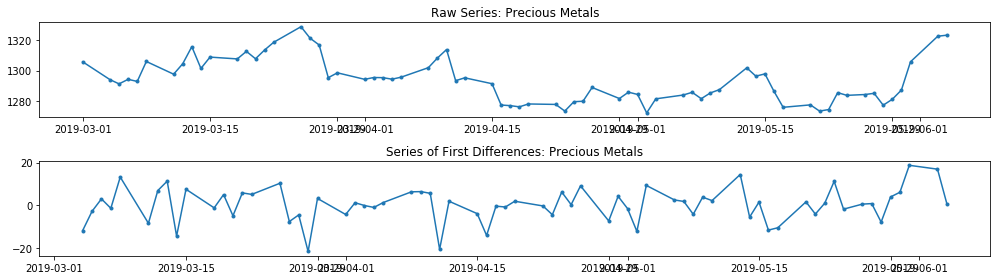

In [267]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, metal, "Precious Metals")
plt.tight_layout()

In [268]:
ADF_test(metal,commodity)

Gold  ADF p-value: 0.23
A low p-value would indicate the data are stationary


In [269]:
metal_diff = metal.diff()[1:]

In [270]:
ADF_test(metal_diff,commodity)

Gold  ADF p-value: 0.00
A low p-value would indicate the data are stationary


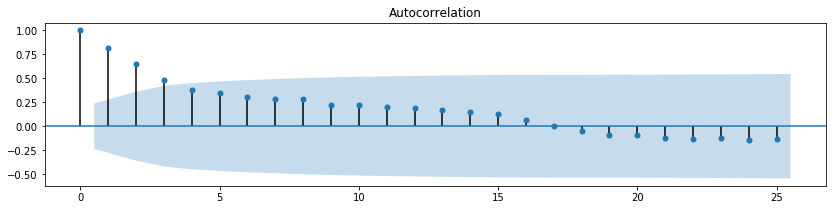

In [271]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(metal, lags=25, ax=ax)

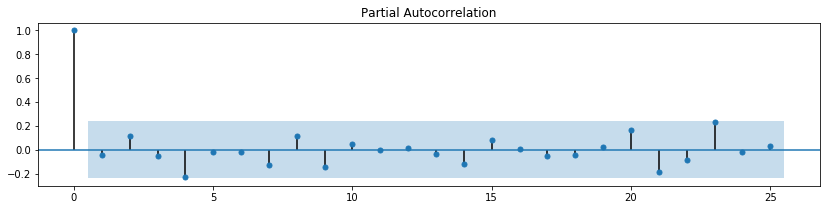

In [272]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_pacf(metal_diff, lags=25, ax=ax)


In [273]:
metal_model = ARIMA(metal, order=(3, 1, 0)).fit()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [274]:
print("ARIMA(3, 1, 0) coefficients from metal model:\n  Intercept {0:2.2f}\n  AR {1}".format(
    metal_model.params[0], 
        format_list_of_floats(list(metal_model.params[1:]))
    ))

ARIMA(3, 1, 0) coefficients from metal model:
  Intercept 0.25
  AR ['-0.03', '0.12', '-0.05']


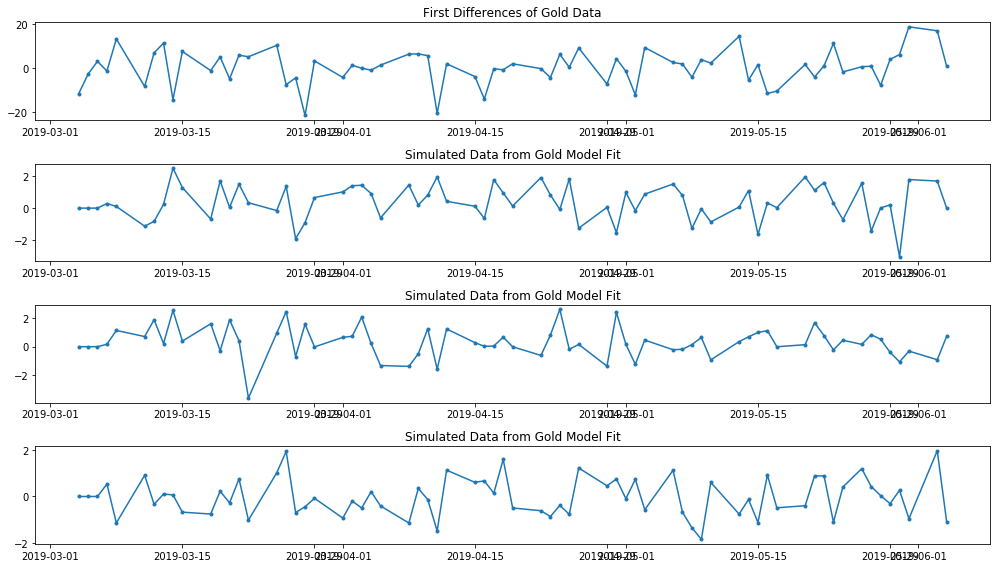

In [275]:
fig, ax = plt.subplots(4, figsize=(14, 8))

ax[0].plot(metal_diff.index, metal_diff, marker='.')
ax[0].set_title("First Differences of "+commodity+" Data")

for i in range(1, 4):
    simulated_data = auto_regressive_process(len(metal_diff), 
                                             np.array(list(metal_model.params)[1:]))
    simulated_data.index = metal_diff.index
    ax[i].plot(simulated_data.index, simulated_data, marker='.')
    ax[i].set_title("Simulated Data from "+commodity+" Model Fit")
    
plt.tight_layout()

In [292]:
next_day = pd.to_datetime(end_date) + td(days=1)
next_year = pd.to_datetime(end_date,) + td(days=365)
next_day = next_day.date()
next_year.year
end_date

'2019-06-04'

In [298]:
metal.reindex(pd.DatetimeIndex(start=start_date, end=next_year.year, freq='D'))
metal.index

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  """Entry point for launching an IPython kernel.


DatetimeIndex(['2019-03-01', '2019-03-04', '2019-03-05', '2019-03-06',
               '2019-03-07', '2019-03-08', '2019-03-11', '2019-03-12',
               '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-18',
               '2019-03-19', '2019-03-20', '2019-03-21', '2019-03-22',
               '2019-03-25', '2019-03-26', '2019-03-27', '2019-03-28',
               '2019-03-29', '2019-04-01', '2019-04-02', '2019-04-03',
               '2019-04-04', '2019-04-05', '2019-04-08', '2019-04-09',
               '2019-04-10', '2019-04-11', '2019-04-12', '2019-04-15',
               '2019-04-16', '2019-04-17', '2019-04-18', '2019-04-19',
               '2019-04-22', '2019-04-23', '2019-04-24', '2019-04-25',
               '2019-04-26', '2019-04-29', '2019-04-30', '2019-05-01',
               '2019-05-02', '2019-05-03', '2019-05-06', '2019-05-07',
               '2019-05-08', '2019-05-09', '2019-05-10', '2019-05-13',
               '2019-05-14', '2019-05-15', '2019-05-16', '2019-05-17',
      

In [299]:
metal.reindex(pd.DatetimeIndex(start=start_date, end=next_year.year, freq='D'))

fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(metal.index, metal, marker='.')
fig = metal_model.plot_predict(end_date, next_year.year, 
                                  dynamic=True, ax=ax, plot_insample=False)

_ = ax.legend().get_texts()[1].set_text("95% Prediction Interval")
_ = ax.legend(loc="lower left")

_ = ax.set_title(name+" Series Forcasts from ARIMA Model")


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:564: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:564: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


ValueError: year 0 is out of range

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x118f0cf28> (for post_execute):


ValueError: year 0 is out of range

ValueError: year 0 is out of range